In [1]:
# Standard Library Imports
import pandas as pd
import re
import time
import datetime
from collections import defaultdict, Counter

# Third-party Library Imports
import requests
from bs4 import BeautifulSoup
import praw
import nltk
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.util import bigrams
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import string

In [2]:
# Set pandas display options to show the entire content of the "Post Text" column
pd.set_option('display.max_colwidth', None)

In [19]:
# Specify the path to your CSV file
csv_file_path = 'reddit (no empty rows).csv'

# Read the CSV file into a DataFrame
df_reddit_post = pd.read_csv(csv_file_path)

# Now, 'df' contains your data from the CSV file

len(df_reddit_post)

3960

In [4]:
df_reddit_post.head()

,title,post_text,id,score,total_comments,post_url,subreddit,post_type,title_&_text,title_text_stemmed,title_text_lemmatized,trending
0,Daily Fasting Check-in!,"* **Type** of fast (water, juice, smoking, etc.)\n* **Context** of fast (start, end, day x of y, etc.)\n* **Length** of fast (8 hours, 3 days, etc.)\n* **Why?** What you hope to accomplish with your fast\n* **Notes** How is it going so far? Any concerns? Insights to share?\n\nBe sure to check back often as comments get posted throughout the day. Sort comments by ""new"" to be sure the newer comments get some love as well.",16o7z6r,1,2,https://www.reddit.com/r/intermittentfasting/comments/16o7z6r/daily_fasting_checkin/,intermittentfasting,hot,"Daily Fasting Check-in! * **Type** of fast (water, juice, smoking, etc.)\n* **Context** of fast (start, end, day x of y, etc.)\n* **Length** of fast (8 hours, 3 days, etc.)\n* **Why?** What you hope to accomplish with your fast\n* **Notes** How is it going so far? Any concerns? Insights to share?\n\nBe sure to check back often as comments get posted throughout the day. Sort comments by ""new"" to be sure the newer comments get some love as well.","['daili', 'checkin', 'type', 'fast', 'water', 'juic', 'smoke', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'go', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'post', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']","['daily', 'checkin', 'type', 'fast', 'water', 'juice', 'smoking', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'going', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'posted', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']",2
1,I decided who I wanted to be and I became her 💅🏽,"So a little background: I’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. I’m sitting around 150 lbs right now. It’s been almost 3 years since I started this intermittent fasting lifestyle and it’s the first time I didn’t gain ALL OF the weight back plus more. But I did fall off a bit last year and gained back about 25 lbs, 20 of which I’ve lost again. That regain did teach me something though. About how to handle stress. About not giving up when there are setbacks. About being grateful for every stage of the journey you’re at. I’ve currently been doing mostly a 20/4 schedule but eating whatever I want to satiety within my window… and the rest of the time I’m just chillin’. 😎",16ntqoy,1176,36,https://i.redd.it/fclkjnwhmgpb1.jpg,intermittentfasting,hot,"I decided who I wanted to be and I became her 💅🏽 So a little background: I’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. I’m sitting around 150 lbs right now. It’s been almost 3 years since I started this intermittent fasting lifestyle and it’s the first time I didn’t gain ALL OF the weight back plus more. But I did fall off a bit last year and gained back about 25 lbs, 20 of which I’ve lost again. That regain did teach me something though. About how to handle stress. About not giving up when there are setbacks. About being grateful for every stage of the journey you’re at. I’ve currently been doing mostly a 20/4 schedule but eating whatever I want to satiety within my window… and the rest of the time I’m just chillin’. 😎","['decid', 'want', 'becam', 'littl', 'background', '39', 'birth', 'two', 'children', '5', '2', 'use', 'weigh', '220', 'lb', 'decad', 'sit', 'around', '150', 'lb', 'right', 'almost', '3', 'year', 'sinc', 'start', 'lifestyl', 'first', 'gain', 'weight', 'back', 'plu', 'fall', 'bit', 'last', 'year', 'gain', 'back', '25', 'lb', '20', 'lost', 'regain', 'teach', 'someth', 'tho

In [5]:
# Define the regex pattern
pattern = r'^https?:\/\/.*[\r\n]*'

# Apply the regex substitution to the 'Text_Column' using apply and a lambda function
df_reddit_post['post_url'] = df_reddit_post['post_url'].apply(lambda text: re.sub(pattern, '', text, flags=re.MULTILINE))

# Display the updated DataFrame
df_reddit_post

,title,post_text,id,score,total_comments,post_url,subreddit,post_type,title_&_text,title_text_stemmed,title_text_lemmatized,trending
0,Daily Fasting Check-in!,"* **Type** of fast (water, juice, smoking, etc.)\n* **Context** of fast (start, end, day x of y, etc.)\n* **Length** of fast (8 hours, 3 days, etc.)\n* **Why?** What you hope to accomplish with your fast\n* **Notes** How is it going so far? Any concerns? Insights to share?\n\nBe sure to check back often as comments get posted throughout the day. Sort comments by ""new"" to be sure the newer comments get some love as well.",16o7z6r,1,2,,intermittentfasting,hot,"Daily Fasting Check-in! * **Type** of fast (water, juice, smoking, etc.)\n* **Context** of fast (start, end, day x of y, etc.)\n* **Length** of fast (8 hours, 3 days, etc.)\n* **Why?** What you hope to accomplish with your fast\n* **Notes** How is it going so far? Any concerns? Insights to share?\n\nBe sure to check back often as comments get posted throughout the day. Sort comments by ""new"" to be sure the newer comments get some love as well.","['daili', 'checkin', 'type', 'fast', 'water', 'juic', 'smoke', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'go', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'post', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']","['daily', 'checkin', 'type', 'fast', 'water', 'juice', 'smoking', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'going', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'posted', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']",2
1,I decided who I wanted to be and I became her 💅🏽,"So a little background: I’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. I’m sitting around 150 lbs right now. It’s been almost 3 years since I started this intermittent fasting lifestyle and it’s the first time I didn’t gain ALL OF the weight back plus more. But I did fall off a bit last year and gained back about 25 lbs, 20 of which I’ve lost again. That regain did teach me something though. About how to handle stress. About not giving up when there are setbacks. About being grateful for every stage of the journey you’re at. I’ve currently been doing mostly a 20/4 schedule but eating whatever I want to satiety within my window… and the rest of the time I’m just chillin’. 😎",16ntqoy,1176,36,,intermittentfasting,hot,"I decided who I wanted to be and I became her 💅🏽 So a little background: I’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. I’m sitting around 150 lbs right now. It’s been almost 3 years since I started this intermittent fasting lifestyle and it’s the first time I didn’t gain ALL OF the weight back plus more. But I did fall off a bit last year and gained back about 25 lbs, 20 of which I’ve lost again. That regain did teach me something though. About how to handle stress. About not giving up when there are setbacks. About being grateful for every stage of the journey you’re at. I’ve currently been doing mostly a 20/4 schedule but eating whatever I want to satiety within my window… and the rest of the time I’m just chillin’. 😎","['decid', 'want', 'becam', 'littl', 'background', '39', 'birth', 'two', 'children', '5', '2', 'use', 'weigh', '220', 'lb', 'decad', 'sit', 'around', '150', 'lb', 'right', 'almost', '3', 'year', 'sinc', 'start', 'lifestyl', 'first', 'gain', 'weight', 'back', 'plu', 'fall', 'bit', 'last', 'year', 'gain', 'back', '25', 'lb', '20', 'lost', 'regain', 'teach', 'someth', 'though', 'handl', 'stress', 'give', 'setback', 'grate', 'stage', 'journey', 'current', 'mostli', '204', 'schedul', 'eat', 

In [6]:
# Define a regular expression pattern to identify image links
image_pattern = r'\b(?:https?://\S+\.(?:jpg|jpeg|png|gif|bmp|svg|webp))\b'

# Create a function to check if any column contains an image link
def contains_image_link(row):
    for column in df_reddit_post.columns:
        if isinstance(row[column], str) and re.search(image_pattern, row[column], re.IGNORECASE):
            return True
    return False

# Apply the function to filter rows with image links
non_image_posts = df_reddit_post[~df_reddit_post.apply(contains_image_link, axis=1)]

# Save the non-image posts to a new CSV file
non_image_posts.to_csv('reddit_posts_non_image.csv', index=False)

In [7]:
non_image_posts.head()

,title,post_text,id,score,total_comments,post_url,subreddit,post_type,title_&_text,title_text_stemmed,title_text_lemmatized,trending
0,Daily Fasting Check-in!,"* **Type** of fast (water, juice, smoking, etc.)\n* **Context** of fast (start, end, day x of y, etc.)\n* **Length** of fast (8 hours, 3 days, etc.)\n* **Why?** What you hope to accomplish with your fast\n* **Notes** How is it going so far? Any concerns? Insights to share?\n\nBe sure to check back often as comments get posted throughout the day. Sort comments by ""new"" to be sure the newer comments get some love as well.",16o7z6r,1,2,,intermittentfasting,hot,"Daily Fasting Check-in! * **Type** of fast (water, juice, smoking, etc.)\n* **Context** of fast (start, end, day x of y, etc.)\n* **Length** of fast (8 hours, 3 days, etc.)\n* **Why?** What you hope to accomplish with your fast\n* **Notes** How is it going so far? Any concerns? Insights to share?\n\nBe sure to check back often as comments get posted throughout the day. Sort comments by ""new"" to be sure the newer comments get some love as well.","['daili', 'checkin', 'type', 'fast', 'water', 'juic', 'smoke', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'go', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'post', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']","['daily', 'checkin', 'type', 'fast', 'water', 'juice', 'smoking', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'going', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'posted', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']",2
1,I decided who I wanted to be and I became her 💅🏽,"So a little background: I’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. I’m sitting around 150 lbs right now. It’s been almost 3 years since I started this intermittent fasting lifestyle and it’s the first time I didn’t gain ALL OF the weight back plus more. But I did fall off a bit last year and gained back about 25 lbs, 20 of which I’ve lost again. That regain did teach me something though. About how to handle stress. About not giving up when there are setbacks. About being grateful for every stage of the journey you’re at. I’ve currently been doing mostly a 20/4 schedule but eating whatever I want to satiety within my window… and the rest of the time I’m just chillin’. 😎",16ntqoy,1176,36,,intermittentfasting,hot,"I decided who I wanted to be and I became her 💅🏽 So a little background: I’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. I’m sitting around 150 lbs right now. It’s been almost 3 years since I started this intermittent fasting lifestyle and it’s the first time I didn’t gain ALL OF the weight back plus more. But I did fall off a bit last year and gained back about 25 lbs, 20 of which I’ve lost again. That regain did teach me something though. About how to handle stress. About not giving up when there are setbacks. About being grateful for every stage of the journey you’re at. I’ve currently been doing mostly a 20/4 schedule but eating whatever I want to satiety within my window… and the rest of the time I’m just chillin’. 😎","['decid', 'want', 'becam', 'littl', 'background', '39', 'birth', 'two', 'children', '5', '2', 'use', 'weigh', '220', 'lb', 'decad', 'sit', 'around', '150', 'lb', 'right', 'almost', '3', 'year', 'sinc', 'start', 'lifestyl', 'first', 'gain', 'weight', 'back', 'plu', 'fall', 'bit', 'last', 'year', 'gain', 'back', '25', 'lb', '20', 'lost', 'regain', 'teach', 'someth', 'though', 'handl', 'stress', 'give', 'setback', 'grate', 'stage', 'journey', 'current', 'mostli', '204', 'schedul', 'eat', 

In [8]:
# Iterate through all columns and convert text data to lowercase
for column in non_image_posts.columns:
    if non_image_posts[column].dtype == 'object':
        non_image_posts[column] = non_image_posts[column].str.lower()

# Print the resulting DataFrame
non_image_posts.head()

C:\Users\weege\AppData\Local\Temp\ipykernel_27536\799003709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_image_posts[column] = non_image_posts[column].str.lower()


,title,post_text,id,score,total_comments,post_url,subreddit,post_type,title_&_text,title_text_stemmed,title_text_lemmatized,trending
0,daily fasting check-in!,"* **type** of fast (water, juice, smoking, etc.)\n* **context** of fast (start, end, day x of y, etc.)\n* **length** of fast (8 hours, 3 days, etc.)\n* **why?** what you hope to accomplish with your fast\n* **notes** how is it going so far? any concerns? insights to share?\n\nbe sure to check back often as comments get posted throughout the day. sort comments by ""new"" to be sure the newer comments get some love as well.",16o7z6r,1,2,,intermittentfasting,hot,"daily fasting check-in! * **type** of fast (water, juice, smoking, etc.)\n* **context** of fast (start, end, day x of y, etc.)\n* **length** of fast (8 hours, 3 days, etc.)\n* **why?** what you hope to accomplish with your fast\n* **notes** how is it going so far? any concerns? insights to share?\n\nbe sure to check back often as comments get posted throughout the day. sort comments by ""new"" to be sure the newer comments get some love as well.","['daili', 'checkin', 'type', 'fast', 'water', 'juic', 'smoke', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'go', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'post', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']","['daily', 'checkin', 'type', 'fast', 'water', 'juice', 'smoking', 'etc', 'context', 'fast', 'start', 'end', 'day', 'x', 'etc', 'length', 'fast', '8', 'hour', '3', 'day', 'etc', 'hope', 'accomplish', 'fast', 'note', 'going', 'far', 'concern', 'insight', 'share', 'sure', 'check', 'back', 'often', 'comment', 'get', 'posted', 'throughout', 'day', 'sort', 'comment', 'new', 'sure', 'newer', 'comment', 'get', 'love', 'well']",2
1,i decided who i wanted to be and i became her 💅🏽,"so a little background: i’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. i’m sitting around 150 lbs right now. it’s been almost 3 years since i started this intermittent fasting lifestyle and it’s the first time i didn’t gain all of the weight back plus more. but i did fall off a bit last year and gained back about 25 lbs, 20 of which i’ve lost again. that regain did teach me something though. about how to handle stress. about not giving up when there are setbacks. about being grateful for every stage of the journey you’re at. i’ve currently been doing mostly a 20/4 schedule but eating whatever i want to satiety within my window… and the rest of the time i’m just chillin’. 😎",16ntqoy,1176,36,,intermittentfasting,hot,"i decided who i wanted to be and i became her 💅🏽 so a little background: i’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. i’m sitting around 150 lbs right now. it’s been almost 3 years since i started this intermittent fasting lifestyle and it’s the first time i didn’t gain all of the weight back plus more. but i did fall off a bit last year and gained back about 25 lbs, 20 of which i’ve lost again. that regain did teach me something though. about how to handle stress. about not giving up when there are setbacks. about being grateful for every stage of the journey you’re at. i’ve currently been doing mostly a 20/4 schedule but eating whatever i want to satiety within my window… and the rest of the time i’m just chillin’. 😎","['decid', 'want', 'becam', 'littl', 'background', '39', 'birth', 'two', 'children', '5', '2', 'use', 'weigh', '220', 'lb', 'decad', 'sit', 'around', '150', 'lb', 'right', 'almost', '3', 'year', 'sinc', 'start', 'lifestyl', 'first', 'gain', 'weight', 'back', 'plu', 'fall', 'bit', 'last', 'year', 'gain', 'back', '25', 'lb', '20', 'lost', 'regain', 'teach', 'someth', 'though', 'handl', 'stress', 'give', 'setback', 'grate', 'stage', 'journey', 'current', 'mostli', '204', 'schedul', 'eat', 

In [9]:
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weege\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weege\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weege\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\weege\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
df_kept_columns = pd.DataFrame(non_image_posts)

# Specify the columns to keep
columns_to_keep = ['title_&_text', "score", "total_comments", "trending", "subreddit"]

# Create an empty DataFrame with the desired columns
df_kept_columns = df_kept_columns[columns_to_keep]

# Display the resulting DataFrame
df_kept_columns.head()

,title_&_text,score,total_comments,trending,subreddit
0,"daily fasting check-in! * **type** of fast (water, juice, smoking, etc.)\n* **context** of fast (start, end, day x of y, etc.)\n* **length** of fast (8 hours, 3 days, etc.)\n* **why?** what you hope to accomplish with your fast\n* **notes** how is it going so far? any concerns? insights to share?\n\nbe sure to check back often as comments get posted throughout the day. sort comments by ""new"" to be sure the newer comments get some love as well.",1,2,2,intermittentfasting
1,"i decided who i wanted to be and i became her 💅🏽 so a little background: i’m 39, have birthed two children and at 5’2, used to weigh 220 lbs for about a decade. i’m sitting around 150 lbs right now. it’s been almost 3 years since i started this intermittent fasting lifestyle and it’s the first time i didn’t gain all of the weight back plus more. but i did fall off a bit last year and gained back about 25 lbs, 20 of which i’ve lost again. that regain did teach me something though. about how to handle stress. about not giving up when there are setbacks. about being grateful for every stage of the journey you’re at. i’ve currently been doing mostly a 20/4 schedule but eating whatever i want to satiety within my window… and the rest of the time i’m just chillin’. 😎",1176,36,42336,intermittentfasting
2,"some photos from a past vacation came up as a memory today. really emotional looking back at how far i’ve come. started if in 2020 & have kept up with it since then. 225lb to 125lb! i remember being miserable and insecure the entire time i was on this trip, it was really hard to enjoy myself. it was about more than just the weight- thankful to be in a better place physically and mentally these days!!",1505,77,115885,intermittentfasting
3,"anybody find if, lose weight, and then lose motivation because you know that you can always lose weight, so you procrastinate about losing weight? i know i am an idiot.",198,78,15444,intermittentfasting
4,"2 and a half months of if from 234 to 211 in 2.5 months. it works! once i got disciplined with fasting it became so easy to stay consistent. i had rapid weight gain due to a medication but now feeling much more confident. to compliment if, i do cardio 3-4 times a week. 11 more pounds to go !! you can do this !",180,12,2160,intermittentfasting


In [11]:
# Define a function to remove punctuation from a string
def remove_punctuation(text):
    if isinstance(text, str):  # Check if the input is a string
        return ''.join([char for char in text if char not in string.punctuation])
    else:
        return text  # Return the original value if it's not a string

# Apply the remove_punctuation function to all columns using applymap
df_cleaned = df_kept_columns.applymap(remove_punctuation)

# Display the cleaned DataFrame
df_cleaned.head()

,title_&_text,score,total_comments,trending,subreddit
0,daily fasting checkin type of fast water juice smoking etc\n context of fast start end day x of y etc\n length of fast 8 hours 3 days etc\n why what you hope to accomplish with your fast\n notes how is it going so far any concerns insights to share\n\nbe sure to check back often as comments get posted throughout the day sort comments by new to be sure the newer comments get some love as well,1,2,2,intermittentfasting
1,i decided who i wanted to be and i became her 💅🏽 so a little background i’m 39 have birthed two children and at 5’2 used to weigh 220 lbs for about a decade i’m sitting around 150 lbs right now it’s been almost 3 years since i started this intermittent fasting lifestyle and it’s the first time i didn’t gain all of the weight back plus more but i did fall off a bit last year and gained back about 25 lbs 20 of which i’ve lost again that regain did teach me something though about how to handle stress about not giving up when there are setbacks about being grateful for every stage of the journey you’re at i’ve currently been doing mostly a 204 schedule but eating whatever i want to satiety within my window… and the rest of the time i’m just chillin’ 😎,1176,36,42336,intermittentfasting
2,some photos from a past vacation came up as a memory today really emotional looking back at how far i’ve come started if in 2020 have kept up with it since then 225lb to 125lb i remember being miserable and insecure the entire time i was on this trip it was really hard to enjoy myself it was about more than just the weight thankful to be in a better place physically and mentally these days,1505,77,115885,intermittentfasting
3,anybody find if lose weight and then lose motivation because you know that you can always lose weight so you procrastinate about losing weight i know i am an idiot,198,78,15444,intermittentfasting
4,2 and a half months of if from 234 to 211 in 25 months it works once i got disciplined with fasting it became so easy to stay consistent i had rapid weight gain due to a medication but now feeling much more confident to compliment if i do cardio 34 times a week 11 more pounds to go you can do this,180,12,2160,intermittentfasting


In [12]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# Create a function to process and modify text
def process_text(text):
    if isinstance(text, str):
        doc = nlp(text)
        modified_tokens = []
        for token in doc:
            if token.text.lower() == "i'm":
                modified_tokens.extend(["i", "am"])
            elif token.text.lower() == "emma's":
                modified_tokens.append("emma")
            else:
                modified_tokens.append(token.text)
        return " ".join(modified_tokens)
    else:
        return text

# Loop through all columns and apply the processing function
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column] = df_cleaned[column].apply(process_text)

# Print the resulting DataFrame
df_cleaned

,title_&_text,score,total_comments,trending,subreddit
0,daily fasting checkin type of fast water juice smoking etc \n context of fast start end day x of y etc \n length of fast 8 hours 3 days etc \n why what you hope to accomplish with your fast \n notes how is it going so far any concerns insights to share \n\n be sure to check back often as comments get posted throughout the day sort comments by new to be sure the newer comments get some love as well,1,2,2,intermittentfasting
1,i decided who i wanted to be and i became her 💅 🏽 so a little background i ’m 39 have birthed two children and at 5’2 used to weigh 220 lbs for about a decade i ’m sitting around 150 lbs right now it ’s been almost 3 years since i started this intermittent fasting lifestyle and it ’s the first time i did n’t gain all of the weight back plus more but i did fall off a bit last year and gained back about 25 lbs 20 of which i ’ve lost again that regain did teach me something though about how to handle stress about not giving up when there are setbacks about being grateful for every stage of the journey you ’re at i ’ve currently been doing mostly a 204 schedule but eating whatever i want to satiety within my window … and the rest of the time i ’m just chillin ’ 😎,1176,36,42336,intermittentfasting
2,some photos from a past vacation came up as a memory today really emotional looking back at how far i ’ve come started if in 2020 have kept up with it since then 225 lb to 125 lb i remember being miserable and insecure the entire time i was on this trip it was really hard to enjoy myself it was about more than just the weight thankful to be in a better place physically and mentally these days,1505,77,115885,intermittentfasting
3,anybody find if lose weight and then lose motivation because you know that you can always lose weight so you procrastinate about losing weight i know i am an idiot,198,78,15444,intermittentfasting
4,2 and a half months of if from 234 to 211 in 25 months it works once i got disciplined with fasting it became so easy to stay consistent i had rapid weight gain due to a medication but now feeling much more confident to compliment if i do cardio 34 times a week 11 more pounds to go you can do this,180,12,2160,intermittentfasting
...,...,...,...,...,...
2484,anyone else have a fear of becoming obese i know that fear of gaining weight is a pretty much universal thing for anorexia but does anyone else have a fear of actual obesity like i ’m genuinely terrified that once i start eating more i just wo n’t stop i ’ll just keep eating and eating and never stop until i ’m 300 pounds because i lost all my self control when i stopped restricting plus hearing about how many people go from anorexia to binge eating disorder does n’t help either i know it ’s not like that for everyone but what if it is for me i ’m so terrified of it that i literally have nightmares about it and imaging it happening makes me feel sick with anxiety i just hope i ’m not the only one cus i feel crazy,89,24,2136,anorexianervosa
2485,i am so alone i ’m a 16 year old male who ’s been suffering from anorexia for two years now entering my 3rd year and have been fake recovered to some extent like 5 times now but every time has me going back down the same path i was on when restricting \n\n i ’m approaching the weight i was at when i was at my worst and everyday i have to deal with constantly being body shamed by my familyfriends who have no idea what i ’m going through no matter how many attempts i ’ve given to explain fully about what i ’m going through \n\n because i ’m a boy i do n’t get a lot of recognition for these struggles i ’m just “ the skinny one who does n’t eat a lot ” in peoples eyes \n\n on top of this i live in a place where there ’s virtually nowhere to go for eating disorders there ’s no programs or people to help me i feel like i ’m approaching the end of my road and at this point i am ready to stop fighting and give up i want to eat i want to recover but i feel 

In [13]:
# Initialize the CountVectorizer for unigrams
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Fit and transform the text into unigrams
unigram_counts = vectorizer.fit_transform(df_cleaned['title_&_text'])
unigram_feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store the unigram counts
unigram_counts_df = pd.DataFrame(unigram_counts.toarray(), columns=unigram_feature_names)

# Add the 'Subreddit' column back to the DataFrame
unigram_counts_df['Subreddit'] = df_cleaned['subreddit']

# Group the DataFrame by 'Subreddit' and sum the counts
grouped_unigram_counts = unigram_counts_df.groupby('Subreddit').sum()

# Now you have the unigram counts for each subreddit
print(grouped_unigram_counts)

                     000  002  005  01  02  03  05  05451130  0615  07  ...  \
Subreddit                                                               ...   
anorexianervosa        1    0    0   0   0   0   0         0     0   0  ...   
intermittentfasting    0    1    1   2   1   1   1         1     1   1  ...   

                     zimmermann  zinc  zma  zombie  zone  zones  zuccini  zyn  \
Subreddit                                                                       
anorexianervosa               0     1    0       4     6      0        1    0   
intermittentfasting           1     0    1       1     7      2        0    1   

                     zyns  zyprexa  
Subreddit                           
anorexianervosa         0        1  
intermittentfasting     3        0  

[2 rows x 12247 columns]


In [14]:
# Initialize the CountVectorizer for bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the text into bigrams
bigram_counts = vectorizer.fit_transform(df_cleaned['title_&_text'])
bigram_feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store the bigram counts
bigram_counts_df = pd.DataFrame(bigram_counts.toarray(), columns=bigram_feature_names)

# Add the 'Subreddit' column back to the DataFrame
bigram_counts_df['Subreddit'] = df_cleaned['subreddit']

# Group the DataFrame by 'Subreddit' and sum the counts
grouped_bigram_counts = bigram_counts_df.groupby('Subreddit').sum()

# Now you have the bigram counts for each subreddit
print(grouped_bigram_counts)

                     000 jeans  002 carbs  005 muscle  01 and  01 now  \
Subreddit                                                               
anorexianervosa              1          0           0       0       0   
intermittentfasting          0          1           1       1       1   

                     02 mmoll  03 kg  05 lbs  05451130 what  0615 hrs  ...  \
Subreddit                                                              ...   
anorexianervosa             0      0       0              0         0  ...   
intermittentfasting         1      1       1              1         1  ...   

                     zone yayayyayay  zone your  zones away  zones hip  \
Subreddit                                                                
anorexianervosa                    1          1           0          0   
intermittentfasting                0          0           1          1   

                     zuccini for  zyn would  zyns bought  zyns in  zyns would  \
Subreddit       

In [15]:
# Initialize the CountVectorizer for trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3))

# Fit and transform the text into trigrams
trigram_counts = vectorizer.fit_transform(df_cleaned['title_&_text'])
trigram_feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store the trigram counts
trigram_counts_df = pd.DataFrame(trigram_counts.toarray(), columns=trigram_feature_names)

# Add the 'Subreddit' column back to the DataFrame
trigram_counts_df['Subreddit'] = df_cleaned['subreddit']

# Group the DataFrame by 'Subreddit' and sum the counts
grouped_trigram_counts = trigram_counts_df.groupby('Subreddit').sum()

# Now you have the trigram counts for each subreddit
print(grouped_trigram_counts)

                     000 jeans depending  005 muscle mass  01 and ca  \
Subreddit                                                              
anorexianervosa                        1                0          0   
intermittentfasting                    0                1          1   

                     01 now just  02 mmoll then  03 kg how  05 lbs or  \
Subreddit                                                               
anorexianervosa                0              0          0          0   
intermittentfasting            1              1          1          1   

                     05451130 what time  0615 hrs restricted  07 kg in  ...  \
Subreddit                                                               ...   
anorexianervosa                       0                    0         0  ...   
intermittentfasting                   1                    1         1  ...   

                     zone thigh is  zone your health  zones away hour  \
Subreddit                   

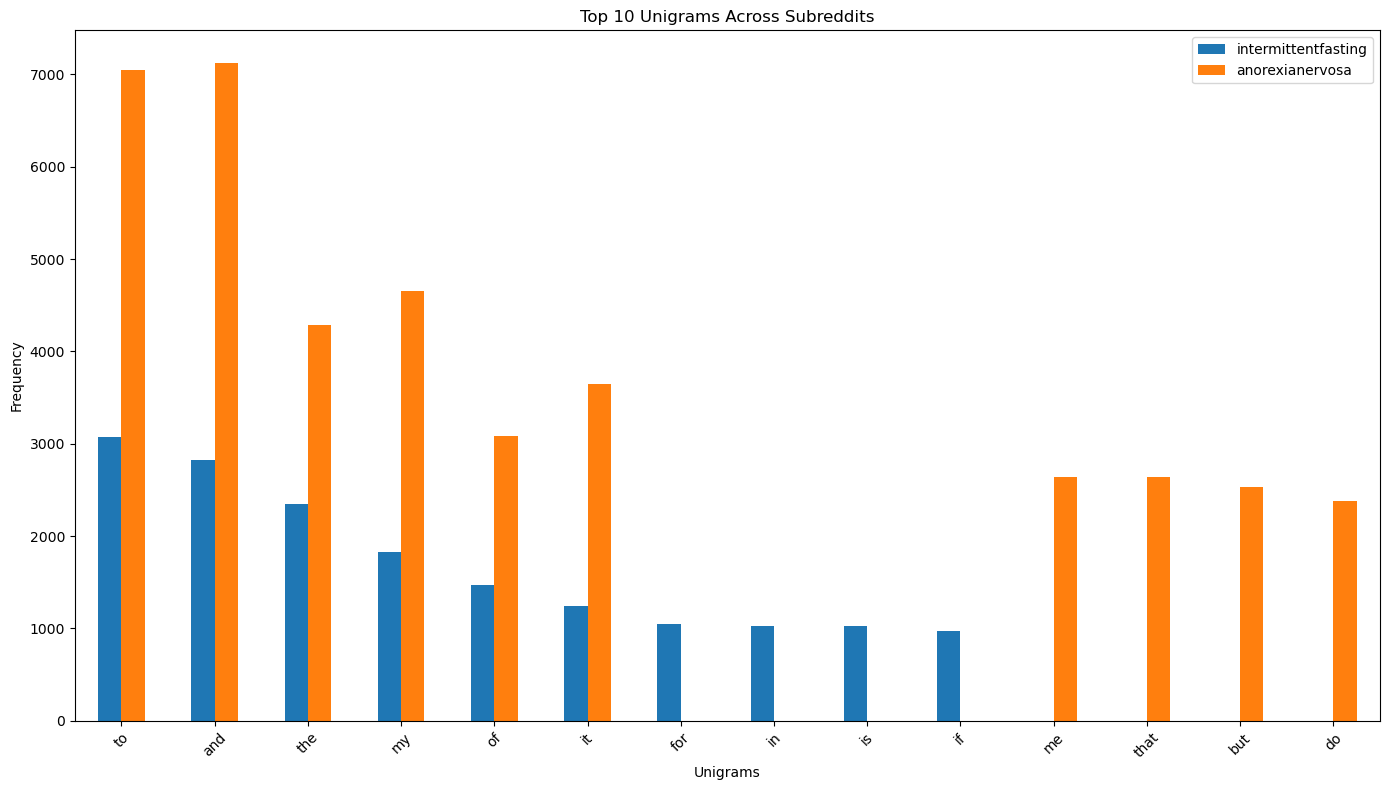

In [16]:
# Get a list of unique subreddits from your DataFrame
unique_subreddits = df_cleaned['subreddit'].unique()

# Number of top unigrams to display
top_n = 10  # Replace with the desired number

# Initialize a DataFrame to store the combined unigram counts
combined_counts_df = pd.DataFrame()

# Initialize a list to store legend labels
legend_labels = []

# Loop through each unique subreddit
for subreddit_name in unique_subreddits:
    # Filter the DataFrame to get data for the current subreddit
    subreddit_data = df_cleaned[df_cleaned['subreddit'] == subreddit_name]

    # Initialize the CountVectorizer for unigrams
    ngram_range = (1, 1)
    vectorizer = CountVectorizer(ngram_range=ngram_range)

    # Fit and transform the text into unigrams
    ngram_counts = vectorizer.fit_transform(subreddit_data['title_&_text'])
    ngram_feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame to store the unigram counts
    ngram_counts_df = pd.DataFrame(ngram_counts.toarray(), columns=ngram_feature_names)

    # Sum the unigram counts
    unigram_counts = ngram_counts_df.sum()

    # Sort the unigram counts in descending order
    top_unigrams = unigram_counts.nlargest(top_n)

    # Append the top unigrams for this subreddit to the combined counts DataFrame
    combined_counts_df = pd.concat([combined_counts_df, top_unigrams], axis=1)

    # Add the subreddit name to the legend labels list
    legend_labels.append(subreddit_name)

# Create a bar chart for the combined unigram counts with legend labels
plt.figure(figsize=(14, 8))
combined_counts_df.plot(kind='bar', ax=plt.gca())
plt.xlabel('Unigrams')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Unigrams Across Subreddits')
plt.xticks(rotation=45)
plt.legend(legend_labels)  # Set the legend labels
plt.tight_layout()
plt.show()

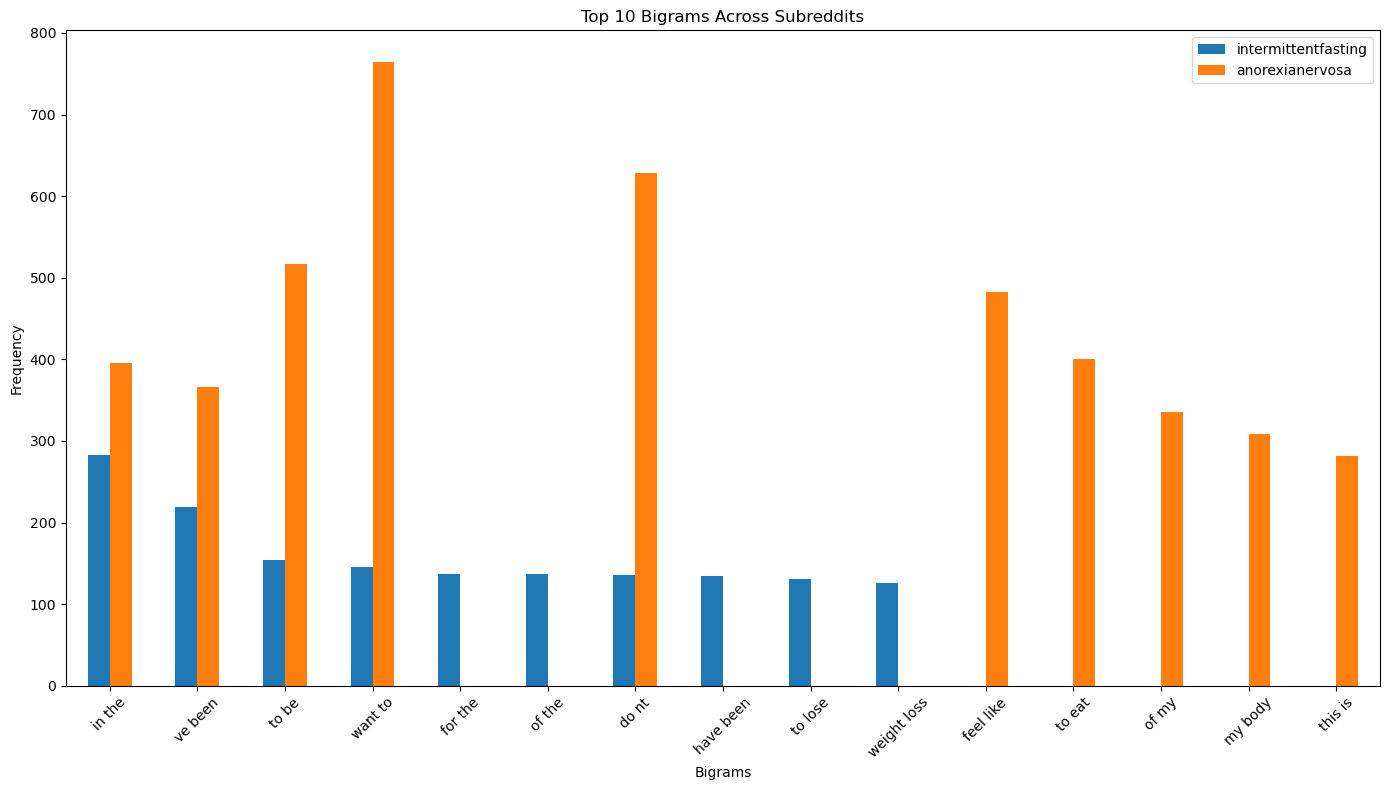

In [17]:
# Get a list of unique subreddits from your DataFrame
unique_subreddits = df_cleaned['subreddit'].unique()

# Number of top bigrams to display
top_n = 10  # Replace with the desired number

# Initialize a DataFrame to store the combined bigram counts
combined_counts_df = pd.DataFrame()

# Initialize a list to store legend labels
legend_labels = []

# Loop through each unique subreddit
for subreddit_name in unique_subreddits:
    # Filter the DataFrame to get data for the current subreddit
    subreddit_data = df_cleaned[df_cleaned['subreddit'] == subreddit_name]

    # Initialize the CountVectorizer for bigrams
    ngram_range = (2, 2)
    vectorizer = CountVectorizer(ngram_range=ngram_range)

    # Fit and transform the text into bigrams
    ngram_counts = vectorizer.fit_transform(subreddit_data['title_&_text'])
    ngram_feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame to store the bigram counts
    ngram_counts_df = pd.DataFrame(ngram_counts.toarray(), columns=ngram_feature_names)

    # Sum the bigram counts
    bigram_counts = ngram_counts_df.sum()

    # Sort the bigram counts in descending order
    top_bigrams = bigram_counts.nlargest(top_n)

    # Append the top bigrams for this subreddit to the combined counts DataFrame
    combined_counts_df = pd.concat([combined_counts_df, top_bigrams], axis=1)

    # Add the subreddit name to the legend labels list
    legend_labels.append(subreddit_name)

# Create a bar chart for the combined bigram counts with legend labels
plt.figure(figsize=(14, 8))
combined_counts_df.plot(kind='bar', ax=plt.gca())
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Bigrams Across Subreddits')
plt.xticks(rotation=45)
plt.legend(legend_labels)  # Set the legend labels
plt.tight_layout()
plt.show()

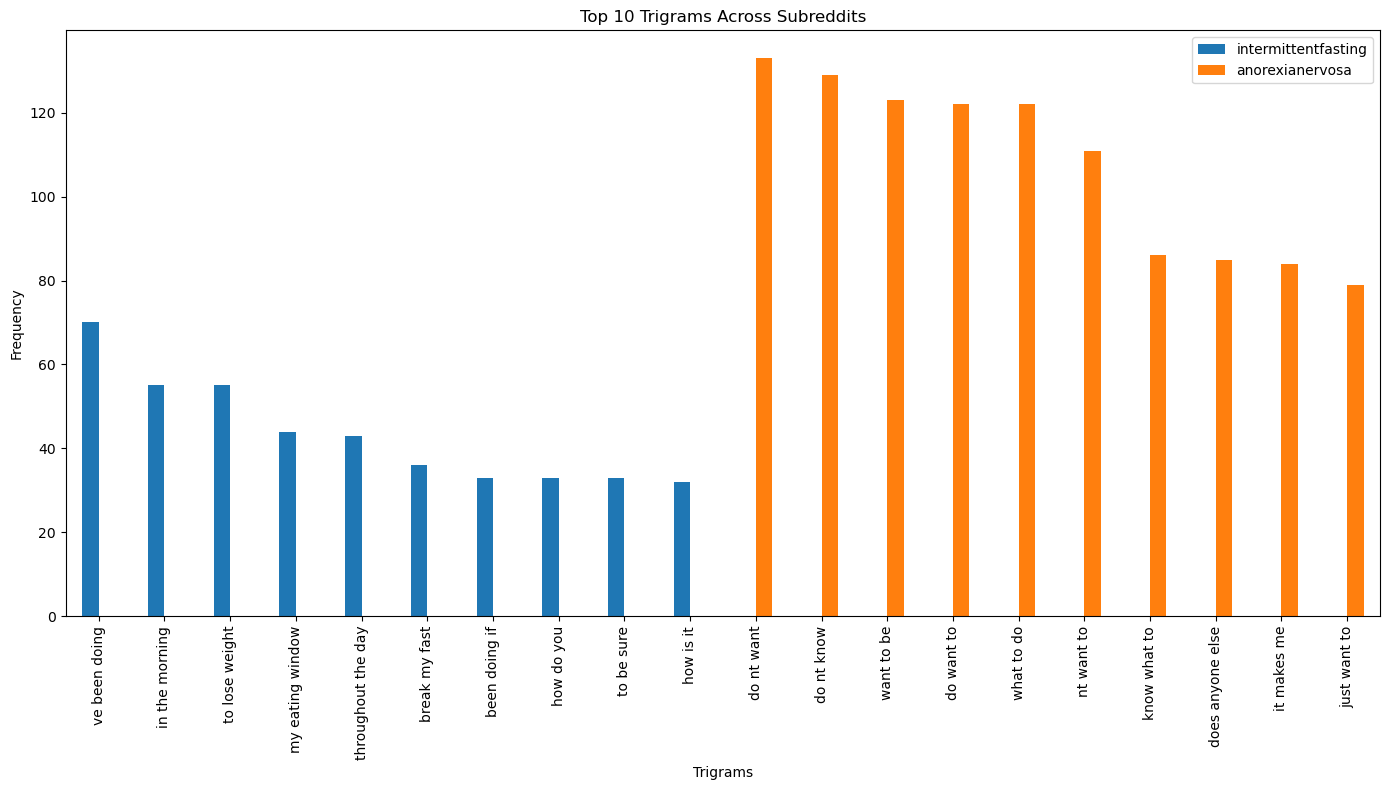

In [18]:
# Get a list of unique subreddits from your DataFrame
unique_subreddits = df_cleaned['subreddit'].unique()

# Number of top trigrams to display
top_n = 10  # Replace with the desired number

# Initialize a DataFrame to store the combined trigram counts
combined_counts_df = pd.DataFrame()

# Initialize a list to store legend labels
legend_labels = []

# Loop through each unique subreddit
for subreddit_name in unique_subreddits:
    # Filter the DataFrame to get data for the current subreddit
    subreddit_data = df_cleaned[df_cleaned['subreddit'] == subreddit_name]

    # Initialize the CountVectorizer for trigrams
    ngram_range = (3, 3)
    vectorizer = CountVectorizer(ngram_range=ngram_range)

    # Fit and transform the text into trigrams
    ngram_counts = vectorizer.fit_transform(subreddit_data['title_&_text'])
    ngram_feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame to store the trigram counts
    ngram_counts_df = pd.DataFrame(ngram_counts.toarray(), columns=ngram_feature_names)

    # Sum the trigram counts
    trigram_counts = ngram_counts_df.sum()

    # Sort the trigram counts in descending order
    top_trigrams = trigram_counts.nlargest(top_n)

    # Append the top trigrams for this subreddit to the combined counts DataFrame
    combined_counts_df = pd.concat([combined_counts_df, top_trigrams], axis=1)

    # Add the subreddit name to the legend labels list
    legend_labels.append(subreddit_name)

# Create a bar chart for the combined trigram counts with legend labels
plt.figure(figsize=(14, 8))
combined_counts_df.plot(kind='bar', ax=plt.gca())
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Trigrams Across Subreddits')
plt.xticks(rotation=90)
plt.legend(legend_labels)  # Set the legend labels
plt.tight_layout()
plt.show()